## Group Project Proposal: Interpersonal Relationships' Effects on Students' Grades
### Group 32: Louisa Deetz, Yusen Zhou, and Carol Zhang

The dataset we will be using is related to student performance and can be found at: https://archive.ics.uci.edu/ml/datasets/Student+Performance

The data is on student achievement in secondary education at two Protugeuese schools, and was collected using school reports and questionnaires. For our project, we will be using the data regarding performance in Mathematics. 

We are interested in using the data on students' relationships with others (eg. whether they are in a romantic relationship, the quality of their family relationships, and how much time they spend going out with friends) to predict the effects on their final grade. 

John Hopkins University (2019) states that "school-life balance is important for optimal academic functioning". Therefore, we believe that it is important for students to spend time socializing and building healthy relationships with others. By examining the data and using a classification model with K-nearest neighbours, we hope to find evidence supporting our hypothesis that if students have strong interpersonal relationships, their academic grade in Mathematics will be high. 

In [8]:
# first, we will load the appropriate packages using the library() function
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [9]:
# then we will read in the dataset
student_data <- read_delim(file = "data/student-mat.csv" ,
                   delim = ";") 
student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


### Preliminary Exploratory Data Analysis

[1] 297

mean_goout,mean_famrel
<dbl>,<dbl>
3.026936,3.979798


`summarise()` ungrouping output (override with `.groups` argument)



romantic,n,percentage
<dbl>,<int>,<dbl>
0,200,67.34007
1,97,32.65993


integer(0)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



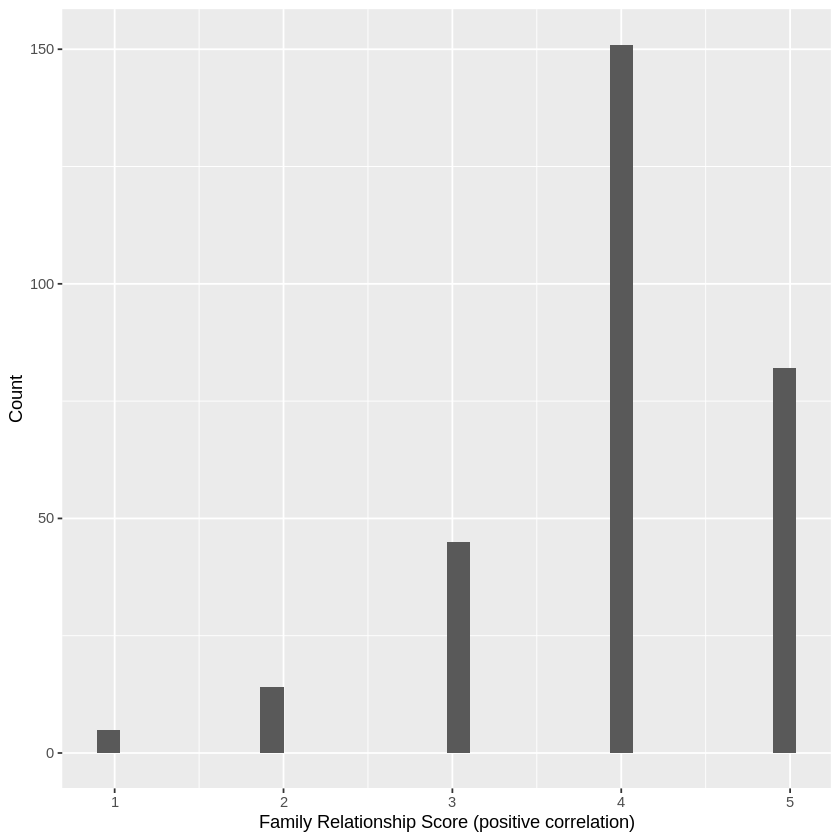

ERROR: Error in layer(data = data, mapping = mapping, stat = stat, geom = GeomBar, : object 'red' not found


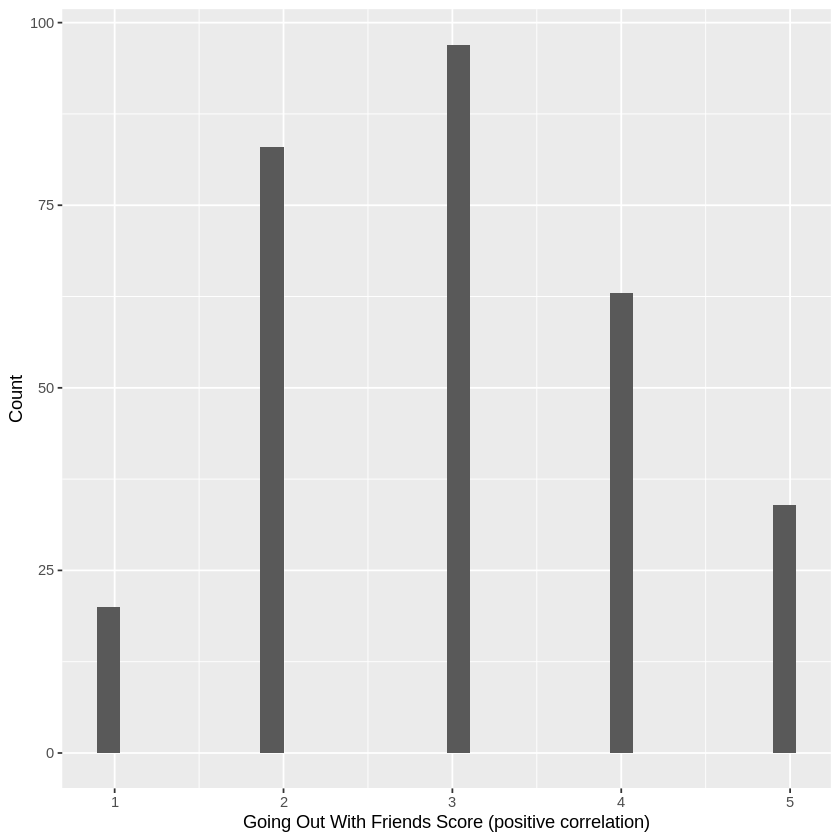

In [22]:
# data appears to be in a tidy format 

# wrangle data to only inclue our vectors of interest: romantic relationship (romantic), family relationship (famrel), going out with friends (goout), 
# and final grade (G3). save as a data frame. 

social_student_data <- student_data %>% 
                            select(romantic, famrel, goout, G3) %>% 
                                as.data.frame()

# assign classifier (final grade) as factor, change 'yes/no' to numeric value

social_student_data <- social_student_data %>% 
                            mutate(G3 = as_factor(G3)) %>% 
                            mutate(romantic = nchar(romantic)-2)

# split the data into training set and testing set

student_split <- initial_split(social_student_data, prop = 0.75, strata = G3)  
student_train <- training(student_split)   
student_test <- testing(student_split)

# exploring the training data
# explore the number of observations 
num_obs <- nrow(student_train)
num_obs

# explore mean of predictors famrel and goout 
student_train %>%
        summarize(mean_goout = mean(goout),
                  mean_famrel = mean(famrel))

# explore number of students in romantic realtionships vs. not 
num_obs <- nrow(student_train)
student_train %>%
  group_by(romantic) %>%
  summarize(
    n = n(),
    percentage = n() / num_obs * 100)

# see if any missing rows within training set missing 
which(is.na(student_train))

# now we will create a histogram for each of our three predictors in order to visualize the distribution 

# family relationship histogram
famrel_hist <- ggplot(student_train, aes(x = famrel)) +
  geom_histogram() +
    labs(x = "Family Relationship Score (positive correlation)", y = "Count") 
famrel_hist #from this we see the majority of students have a good family relationship (4/5)

# going out with friends histogram
goout_hist <- ggplot(student_train, aes(x = goout)) +
  geom_histogram() +
    labs(x = "Going Out With Friends Score (positive correlation)", y = "Count")
goout_hist #from this we see a pretty even distribution

# romantic relationship histogram
romantic_hist <- ggplot(student_train, aes(x = romantic)) +
  geom_histogram(fill = red) +
    labs(x = "Relationship (YES = 1, NO = 0)", y = "Count")
romantic_hist #from this we see that the majority of students aren't in a romantic relationship

### Methods

For our data analysis, we will build a classification model using K-nearest neighbours. We will be predicting *G3* (final grade) using *romantic* (with a romantic relationship), *famrel* (quality of family relationships), and *goout* (going out with friends) as predictors. 

*G3* has a range of 0 to 20 and we believe that it would be too difficult to build a classification model with 20 possible labels. Therefore, we will be splitting up *G3* using the following system: 0 - 5 : Fail ; 5 - 10 : Bad ; 10 - 15 : Good ; 15 - 20 : Excellent. 

We will also be mutating the column *romantic* from a binary to numeric one, with 1 representing “yes” and 0 representing “no”. 

One of the visualizations we can use to show our results is a scatterplot with two of the predictors on the x and y-axis, and colours for the labels of final grades. We can also use a confusion matrix to show the accuracy of our model. 

### Expected Outcomes and Significance

As stated in our introduction, we hope to find a positive relationship between the quality of students’ interpersonal relationships and their final grades in Mathematics. 

If our hypothesis is proven to be correct and the quality of students’ relationships is found to be an accurate predictor for their academic performance, it will serve as evidence to support the need of a healthy school-life balance. Students are often too focused on studying and academics, so they should remember to regularly spend time with family and friends! 

Since the dataset we are using in our project only includes Mathematics grades, future research should be done to explore the effects on other subjects as well. In addition, it will be interesting to see whether the results are supported by data from students in other countries. 


### References 

John Hopkins University. (2019, November 4). School-life balance. Johns Hopkins Student Assistance Program. https://jhsap.org/self_help_resources/school-life_balance/

Cortez, P., & Silva, A. (2008). Using data mining to predict secondary school student performance. Proceedings of 5th Annual Future Business Technology Conference, 5-12. http://www3.dsi.uminho.pt/pcortez/student.pdf